# Final Results For Master's Thesis

#### Ready Environmetn

In [53]:
import mlflow
import pandas as pd
import numpy as np
import os
from ruamel import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

In [24]:
dataset_name="jakson"
pred_target="ERStatus"
experiment_name = f"san_{dataset_name}_{pred_target}"

In [25]:
all_data_points = pd.DataFrame(columns=["exp_name", "exp_type", "test_balanced_accuracy"])

## Non-Spatial Baselines

### ERless

In [26]:
# Define query for MLFlow
query = """\
    params.lr = '0.0001' and \
    params.n_mlp_layers = '8' and \
    params.scalar = '8' and \
    params.batch_size = '8' and \
    params.run_type = 'space_gm' and \
    params.split_strategy = 'split_basel_leave_zurich_as_external' and \
    params.dataset_name = 'frequency_dataset_ERless'
    """
df = mlflow.search_runs(
        experiment_names=[experiment_name],
        filter_string=query,
)

# Filter out irrelevant runs
df = df.drop(df.loc[df["params.scheduler"]=="['ExponentialLR', 0.98]"].index.values[0])
df = df.loc[df["params.fold"].isnull()]
df = df.drop(df[df.duplicated(subset=["params.seed"])].index.values[0])
d={"exp_name":"non_spatial", "exp_type":"ERless", "test_balanced_accuracy":df["metrics.test_best_val_balanced_accuracy_balanced_accuracy"]}
all_data_points = pd.concat([all_data_points, pd.DataFrame(data=d)], ignore_index=True)

### ER Non-Spatial 

In [27]:
# Define query for MLFlow
query = """\
    params.dataset_name = "frequency_dataset" and \
    params.run_type = "space_gm" and \
    params.split_strategy = "split_basel_leave_zurich_as_external" and \
    params.lr = '0.0001' and \
    params.n_mlp_layers = '8' and \
    params.scalar = '8' and \
    params.batch_size = '8'
    """
#query = 'params.dataset_name = "frequency_dataset" and params.run_type = "space_gm" and params.split_strategy = "split_basel_leave_zurich_as_external"'
df = mlflow.search_runs(
        experiment_names=[experiment_name],
        filter_string=query,
)
df = df.drop(df.loc[df["params.scheduler"]=="['ExponentialLR', 0.98]"].index.values[0])
df = df.drop(df[df.duplicated(subset=["params.seed"])].index.values[0])
d={"exp_name":"non_spatial", "exp_type":"ER", "test_balanced_accuracy":df["metrics.test_best_val_balanced_accuracy_balanced_accuracy"]}
all_data_points = pd.concat([all_data_points, pd.DataFrame(data=d)], ignore_index=True)

## Geometric Baselines

### Set shared path and dictionary of results

In [28]:
geom_exp_name = [
    "all_cells_ERless_contact",
    "all_cells_ERless_radius",
    "all_cells_contact",
    "all_cells_radius",
    "endothelial_ERless_contact",
    "endothelial_contact",
    "endothelial_stromal_ERless_contact",
    "endothelial_stromal_contact",
    "endothelial_tumor_ERless_contact",
    "endothelial_tumor_contact",
    "immune_ERless_radius",
    "immune_endothelial_ERless_radius",
    "immune_endothelial_radius",
    "immune_radius",
    "immune_stromal_ERless_radius",
    "immune_stromal_radius",
    "immune_tumor_ERless_radius",
    "immune_tumor_radius",
    "stromal_ERless_contact",
    "stromal_contact",
    "stromal_tumor_ERless_contact",
    "stromal_tumor_contact",
    "tumor_ERless_contact",
    "tumor_contact",
]
shared_path = "/Users/ast/Downloads/base_configs"

### Get results

In [29]:
for concept in geom_exp_name:
    p = os.path.join(shared_path, f"best_{concept}.yaml")
    with open(p) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        cfg = yaml.load(file, Loader=yaml.Loader)  # TODO: what is the Loader kwarg?

    # Define query for MLFlow
    query = f"""\
        params.concept = "{concept}" and \
        params.split_strategy = "split_basel_leave_zurich_as_external" and \
        params.run_type = "pretrain_concept" and \
        params.pool = "{cfg["pool"][0]}" and \
        params.gnn = "{cfg["gnn"][0]}" and \
        params.lr = "{cfg["lr"][0]}" and \
        params.jk = "{cfg["jk"][0]}" and \
        params.norm = "{cfg["norm"][0]}" and \
        params.num_layers = "{cfg["num_layers"][0]}" and \
        params.scaler = "{cfg["scaler"][0]}"
        """
    #query = 'params.dataset_name = "frequency_dataset" and params.run_type = "space_gm" and params.split_strategy = "split_basel_leave_zurich_as_external"'
    df = mlflow.search_runs(
            experiment_names=[experiment_name],
            filter_string=query,
    )
    
    if "ERless" in concept:
        exp_type = "ERless"
    else:
        exp_type = "ER"
    
    df = df.drop(df[df.duplicated(subset=["params.seed"])].index.values[0])
    d={"exp_name":f"{concept.replace('_ERless','')}", "exp_type":f"{exp_type}", "test_balanced_accuracy":df["metrics.test_best_val_balanced_accuracy_balanced_accuracy"]}
    all_data_points = pd.concat([all_data_points, pd.DataFrame(data=d)], ignore_index=True)

## Graph Concept Learners

In [30]:
gcl_exp_names = [
    "gcl_ER_concat",
    "gcl_ER_linear",
    "gcl_ER_transfromer",
    "gcl_ERless_concat",
    "gcl_ERless_linear",
    "gcl_ERless_transfromer",
]

In [31]:
for gcl_type in gcl_exp_names:
    p = os.path.join(shared_path, f"best_{gcl_type}.yaml")
    with open(p) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        cfg = yaml.load(file, Loader=yaml.Loader)  # TODO: what is the Loader kwarg?

    if "ERless" in gcl_type:
        run_type = "train_ERless_gcl"
        exp_type = "ERless"
        exp_name = gcl_type.replace("_ERless","")
    else:
        run_type = "train_ER_gcl"
        exp_type = "ER"
        exp_name = gcl_type.replace("_ER","")
        
    # Define query for MLFlow
    query = f"""\
        params.split_strategy = "split_basel_leave_zurich_as_external" and \
        params.run_type = "{run_type}" and \
        params.agg_lr = "{cfg["agg_lr"][0]}" and \
        params.gnns_lr = "{cfg["gnns_lr"][0]}" and \
        params.aggregator = "{cfg["aggregator"][0]}" and \
        params.n_heads = "{cfg["n_heads"][0]}" and \
        params.depth = "{cfg["depth"][0]}" and \
        params.scaler = "{cfg["scaler"][0]}"
        """
    #query = 'params.dataset_name = "frequency_dataset" and params.run_type = "space_gm" and params.split_strategy = "split_basel_leave_zurich_as_external"'
    df = mlflow.search_runs(
            experiment_names=[experiment_name],
            filter_string=query,
    )
    df = df.drop(df[df.duplicated(subset=["params.seed"])].index.values[0])
    df = df.drop(df.loc[df["params.scheduler"] == f"{cfg['scheduler'][0]}"].index.values[0])
    d={"exp_name":f"{exp_name}", "exp_type":f"{exp_type}", "test_balanced_accuracy":df["metrics.test_best_val_balanced_accuracy_balanced_accuracy"]}
    all_data_points = pd.concat([all_data_points, pd.DataFrame(data=d)], ignore_index=True)

In [32]:
all_data_points.groupby(by=["exp_name","exp_type"]).describe()

test_balanced_accuracy             
                                                      count      mean   
exp_name                    exp_type                                    
all_cells_contact           ER                        100.0  0.704955  \
                            ERless                    100.0  0.774829   
all_cells_radius            ER                        100.0  0.736299   
                            ERless                    100.0  0.739127   
endothelial_contact         ER                        100.0  0.660769   
                            ERless                    100.0  0.605786   
endothelial_stromal_contact ER                        100.0  0.609277   
                            ERless                    100.0  0.736460   
endothelial_tumor_contact   ER                        100.0  0.806298   
                            ERless                    100.0  0.654780   
gcl_concat                  ER                        100.0  0.953246   
                            ERless                    100.0  0.955440   
gcl_linear                  ER                        100.0  0.939369   
                            ERless                    100.0  0.949686   
gcl_transfromer             ER                        100.0  0.944665   
                            ERless                    100.0  0.957933   
immune_endothelial_radius   ER                        100.0  0.672650   
                            ERless                    100.0  0.701342   
immune_radius               ER                        100.0  0.793561   
                            ERless                    100.0  0.720953   
immune_stromal_radius       ER                        100.0  0.738895   
                            ERless                    100.0  0.732848   
immune_tumor_radius         ER                        100.0  0.748630   
                            ERless                    100.0  0.647125   
non_spatial                 ER                        100.0  0.785773   
                            ERless                    100.0  0.783416   
stromal_contact             ER                        100.0  0.789655   
                            ERless                    100.0  0.753039   
stromal_tumor_contact       ER                        100.0  0.761319   
                            ERless                    100.0  0.678254   
tumor_contact               ER                        100.0  0.708137   
                            ERless                    100.0  0.673062   

                                                                               
                                           std       min       25%       50%   
exp_name                    exp_type                                           
all_cells_contact           ER        0.078764  0.487124  0.672590  0.725724  \
                            ERless    0.043812  0.628666  0.746066  0.780311   
all_cells_radius            ER        0.075497  0.489270  0.708691  0.749508   
                            ERless    0.045970  0.634478  0.706702  0.741685   
endothelial_contact         ER        0.070652  0.500894  0.604368  0.653165   
                            ERless    0.053372  0.500000  0.573610  0.599651   
endothelial_stromal_contact ER        0.095848  0.484979  0.514932  0.620127   
                            ERless    0.049922  0.599249  0.706925  0.737080   
endothelial_tumor_contact   ER        0.061205  0.497854  0.791868  0.817373   
                            ERless    0.120593  0.470225  0.500000  0.705562   
gcl_concat                  ER        0.013551  0.911579  0.946548  0.953496   
                            ERless    0.019613  0.903138  0.942742  0.960010   
gcl_linear                  ER        0.016509  0.898743  0.929810  0.940930   
                            ERless    0.017750  0.893232  0.941644  0.951203   
gcl_transfromer             ER        0.013834  0.895159  0.934050  0.945883   
                            ERless    0.0

## Sanity Checks
### Individual Concepts

In [33]:
sanity_check_all_data_points = pd.DataFrame(columns=["exp_name", "test_balanced_accuracy"])

In [34]:
all_rnd_concepts = [
    "all_cells_contact",
    "all_cells_radius",
    "endothelial_contact",
    "endothelial_stromal_contact",
    "endothelial_tumor_contact",
    "immune_endothelial_radius",
    "immune_radius",
    "immune_stromal_radius",
    "immune_tumor_radius",
    "stromal_contact",
    "stromal_tumor_contact",
    "tumor_contact",
]

In [35]:
for concept in all_rnd_concepts:
    p = os.path.join(shared_path, f"best_{concept}.yaml")
    with open(p) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        cfg = yaml.load(file, Loader=yaml.Loader)  # TODO: what is the Loader kwarg?

    # Define query for MLFlow
    query = f"""\
        params.concept = "{concept}" and \
        params.run_type = 'pretrain_rnd_concept' and \
        params.split_strategy = 'split_basel_leave_zurich_as_external' and \
    """
    df = mlflow.search_runs(
            experiment_names=[experiment_name],
            filter_string=query,
    )
    
    d={"exp_name":f"{concept}", "test_balanced_accuracy":df["metrics.test_best_val_balanced_accuracy_balanced_accuracy"]}
    sanity_check_all_data_points = pd.concat([sanity_check_all_data_points, pd.DataFrame(data=d)], ignore_index=True)

### GCLs

In [36]:
all_rnd_gcls = [
    "gcl_ER_concat",
    "gcl_ER_linear",
    "gcl_ER_transfromer",
]

In [37]:
for gcl_type in all_rnd_gcls:
    p = os.path.join(shared_path, f"best_{gcl_type}.yaml")
    with open(p) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        cfg = yaml.load(file, Loader=yaml.Loader)  # TODO: what is the Loader kwarg?
        
    # Define query for MLFlow
    query = f"""\
        params.split_strategy = "split_basel_leave_zurich_as_external" and \
        params.run_type = "train_rnd_gcl" and \
        params.agg_lr = "{cfg["agg_lr"][0]}" and \
        params.gnns_lr = "{cfg["gnns_lr"][0]}" and \
        params.aggregator = "{cfg["aggregator"][0]}" and \
        params.n_heads = "{cfg["n_heads"][0]}" and \
        params.depth = "{cfg["depth"][0]}" and \
        params.scaler = "{cfg["scaler"][0]}"
        """
    #query = 'params.dataset_name = "frequency_dataset" and params.run_type = "space_gm" and params.split_strategy = "split_basel_leave_zurich_as_external"'
    df = mlflow.search_runs(
            experiment_names=[experiment_name],
            filter_string=query,
    )
    
    d={"exp_name":f"{gcl_type.replace('_ER','')}", "test_balanced_accuracy":df["metrics.test_best_val_balanced_accuracy_balanced_accuracy"]}
    sanity_check_all_data_points = pd.concat([sanity_check_all_data_points, pd.DataFrame(data=d)], ignore_index=True)

In [38]:
sanity_check_all_data_points.groupby(by=["exp_name"]).describe()

test_balanced_accuracy                       
                                             count      mean       std   
exp_name                                                                 
all_cells_contact                            100.0  0.502149  0.027870  \
all_cells_radius                             100.0  0.498747  0.025655   
endothelial_contact                          100.0  0.496627  0.044392   
endothelial_stromal_contact                  100.0  0.503423  0.029289   
endothelial_tumor_contact                    100.0  0.502390  0.033517   
gcl_concat                                   100.0  0.496964  0.043288   
gcl_linear                                   100.0  0.493704  0.044480   
gcl_transfromer                              100.0  0.497043  0.031037   
immune_endothelial_radius                    100.0  0.501838  0.032813   
immune_radius                                100.0  0.497655  0.044755   
immune_stromal_radius                        100.0  0.494697  0.037774   
immune_tumor_radius                          100.0  0.500388  0.032470   
stromal_contact                              100.0  0.500624  0.015730   
stromal_tumor_contact                        100.0  0.500331  0.053143   
tumor_contact                                100.0  0.494992  0.030981   

                                                                               
                                  min       25%       50%       75%       max  
exp_name                                                                       
all_cells_contact            0.358011  0.497854  0.500000  0.512473  0.577164  
all_cells_radius             0.416309  0.490522  0.500000  0.507958  0.607117  
endothelial_contact          0.309549  0.480530  0.500000  0.517592  0.610515  
endothelial_stromal_contact  0.395386  0.497318  0.500000  0.508338  0.595851  
endothelial_tumor_contact    0.407994  0.497116  0.500000  0.507690  0.622049  
gcl_concat                   0.369546  0.467364  0.498569  0.522018  0.604345  
gcl_linear                   0.388054  0.465062  0.497228  0.519582  0.629202  
gcl_transfromer              0.438036  0.475858  0.497541  0.510126  0.579936  
immune_endothelial_radius    0.388323  0.489941  0.500000  0.507220  0.619367  
immune_radius                0.362035  0.468415  0.500000  0.519045  0.600948  
immune_stromal_radius        0.391363  0.474361  0.497049  0.517123  0.579310  
immune_tumor_radius          0.363823  0.487035  0.500000  0.516541  0.593079  
stromal_contact              0.460122  0.493562  0.500000  0.500000  0.563662  
stromal_tumor_contact        0.361946  0.465397  0.497943  0.540348  0.613823  
tumor_contact                0.372675  0.493026  0.500000  0.500000  0.621155

## Format results

In [359]:
idx = pd.Index([
    ("ER", "max"),("ER", "mean"),("ER", "min"),("ER", "std"),
    ("ERless", "max"),("ERless", "mean"),("ERless", "min"),("ERless", "std")
])
all_data_points.groupby(by=["exp_name","exp_type"]).describe().reset_index(col_level=1).droplevel(0, axis=1).pivot(index="exp_name", values=["max","mean","min","std"], columns="exp_type").swaplevel(axis=1).reindex(columns=idx).astype(np.float64).sort_values(by=("ER", "mean"), axis=0).round(3)

ER                      ERless                 
                               max   mean    min    std    max   mean    min   
exp_name                                                                       
endothelial_stromal_contact  0.815  0.609  0.485  0.096  0.835  0.736  0.599  \
endothelial_contact          0.842  0.661  0.501  0.071  0.752  0.606  0.500   
immune_endothelial_radius    0.832  0.673  0.500  0.096  0.785  0.701  0.651   
all_cells_contact            0.856  0.705  0.487  0.079  0.855  0.775  0.629   
tumor_contact                0.869  0.708  0.469  0.110  0.831  0.673  0.475   
all_cells_radius             0.852  0.736  0.489  0.075  0.844  0.739  0.634   
immune_stromal_radius        0.840  0.739  0.543  0.065  0.852  0.733  0.607   
immune_tumor_radius          0.888  0.749  0.498  0.075  0.816  0.647  0.404   
stromal_tumor_contact        0.890  0.761  0.641  0.053  0.892  0.678  0.320   
non_spatial                  0.856  0.786  0.689  0.030  0.837  0.783  0.721   
stromal_contact              0.872  0.790  0.649  0.042  0.847  0.753  0.585   
immune_radius                0.862  0.794  0.650  0.033  0.804  0.721  0.623   
endothelial_tumor_contact    0.880  0.806  0.498  0.061  0.858  0.655  0.470   
gcl_linear                   0.975  0.939  0.899  0.017  0.985  0.950  0.893   
gcl_transfromer              0.983  0.945  0.895  0.014  0.982  0.958  0.902   
gcl_concat                   0.976  0.953  0.912  0.014  0.992  0.955  0.903   

                                    
                               std  
exp_name                            
endothelial_stromal_contact  0.050  
endothelial_contact          0.053  
immune_endothelial_radius    0.027  
all_cells_contact            0.044  
tumor_contact                0.118  
all_cells_radius             0.046  
immune_stromal_radius        0.042  
immune_tumor_radius          0.114  
stromal_tumor_contact        0.119  
non_spatial                  0.032  
stromal_contact              0.038  
immune_radius                0.037  
endothelial_tumor_contact    0.121  
gcl_linear                   0.018  
gcl_transfromer              0.016  
gcl_concat                   0.020

In [97]:
sanity_check_all_data_points.groupby(by=["exp_name"]).describe().reset_index(col_level=1).droplevel(0, axis=1).set_index("exp_name").sort_values(by=("exp_name"), axis=0).round(3)

,count,mean,std,min,25%,50%,75%,max
exp_name,,,,,,,,
all_cells_contact,100.0,0.502,0.028,0.358,0.498,0.500,0.512,0.577
all_cells_radius,100.0,0.499,0.026,0.416,0.491,0.500,0.508,0.607
endothelial_contact,100.0,0.497,0.044,0.310,0.481,0.500,0.518,0.611
endothelial_stromal_contact,100.0,0.503,0.029,0.395,0.497,0.500,0.508,0.596
endothelial_tumor_contact,100.0,0.502,0.034,0.408,0.497,0.500,0.508,0.622
gcl_concat,100.0,0.497,0.043,0.370,0.467,0.499,0.522,0.604
gcl_linear,100.0,0.494,0.044,0.388,0.465,0.497,0.520,0.629
gcl_transfromer,100.0,0.497,0.031,0.438,0.476,0.498,0.510,0.580
immune_endothelial_radius,100.0,0.502,0.033,0.388,0.490,0.500,0.507,0.619


## Violin plots
### ER + ERless

In [3]:
all_data_points = pd.read_csv("/Users/ast/Downloads/results/all_experiments_100_seeds_long_format.csv", index_col=0)
all_data_points

,exp_name,exp_type,test_balanced_accuracy
0,non_spatial,ERless,0.806330
1,non_spatial,ERless,0.748122
2,non_spatial,ERless,0.758852
3,non_spatial,ERless,0.812142
4,non_spatial,ERless,0.751162
...,...,...,...
3195,gcl_transfromer,ERless,0.957717
3196,gcl_transfromer,ERless,0.957717
3197,gcl_transfromer,ERless,0.951203
3198,gcl_transfromer,ERless,0.982115


In [10]:
all_data_points.loc[(all_data_points["exp_name"] == "non_spatial") & (all_data_points["exp_type"] == "ER"), "test_balanced_accuracy"]

100    0.806599
101    0.806599
102    0.782994
103    0.759388
104    0.754202
         ...   
195    0.792203
196    0.742221
197    0.770118
198    0.772264
199    0.795601
Name: test_balanced_accuracy, Length: 100, dtype: float64

In [4]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context("paper")
root_path_results = "/Users/ast/Downloads/results"

In [5]:
idx = pd.Index([
    ("ER", "max"),("ER", "mean"),("ER", "min"),("ER", "std"),("ER", "50%"),
    ("ERless", "max"),("ERless", "mean"),("ERless", "min"),("ERless", "std"),("ERless", "50%")
])
order = all_data_points.groupby(by=["exp_name","exp_type"]).describe().reset_index(col_level=1).droplevel(0, axis=1).pivot(index="exp_name", values=["max","mean","50%","min","std"], columns="exp_type").swaplevel(axis=1).reindex(columns=idx).astype(np.float64).sort_values(by=("ER", "50%"), axis=0).round(3).index.values
order

array(['endothelial_stromal_contact', 'endothelial_contact',
       'immune_endothelial_radius', 'all_cells_contact', 'tumor_contact',
       'all_cells_radius', 'immune_stromal_radius',
       'stromal_tumor_contact', 'immune_tumor_radius', 'non_spatial',
       'immune_radius', 'stromal_contact', 'endothelial_tumor_contact',
       'gcl_linear', 'gcl_transfromer', 'gcl_concat'], dtype=object)

In [6]:
order = np.array(['endothelial_stromal_contact', 'endothelial_contact',
       'immune_endothelial_radius', 'tumor_contact',
       'immune_stromal_radius',
       'stromal_tumor_contact', 'immune_tumor_radius', 
       'immune_radius', 'stromal_contact', 'endothelial_tumor_contact', 
       'all_cells_radius', 'all_cells_contact', 'non_spatial',
       'gcl_linear', 'gcl_concat', "gcl_transfromer"])
better_labels = np.char.title(np.char.replace(np.char.mod('%s', order), '_', ' '))
better_labels[-1] = 'GCL Transformer'
better_labels[-2] = 'GCL Concat'
better_labels[-3] = 'GCL Linear'

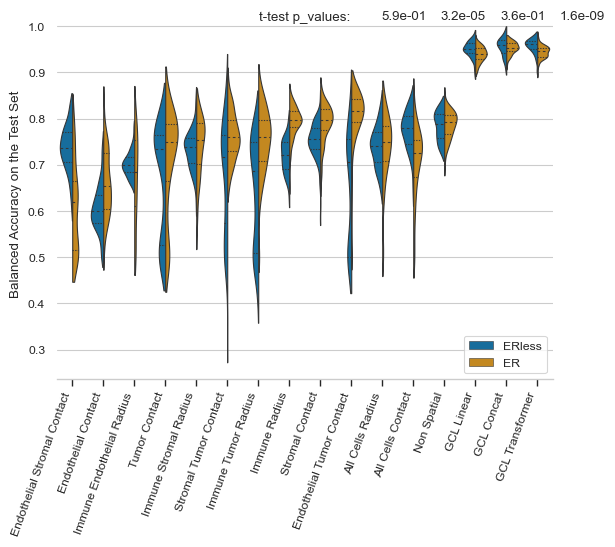

In [67]:
ax = sns.violinplot(linewidth = 0.8,
                    data=all_data_points, 
                    x="exp_name", 
                    y="test_balanced_accuracy",
                    split=True, 
                    hue="exp_type", 
                    order=order,
                    cut=True,
                    scale="area",
                    inner="quartile"
                   )
ax.set_xticklabels(better_labels, 
                   rotation=70,
                   horizontalalignment='right'
                  )
ax.set(xlabel ="", ylabel = "Balanced Accuracy on the Test Set", title ='')
ax.legend(loc='lower right')
ax.tick_params(axis='x', which='both', bottom=True)
sns.despine(left=True)
path_to_file = os.path.join(root_path_results, "violin_plots_ER_ERless.jpg")

# x position
x_offset = 0
for exp in ["non_spatial", 'gcl_linear', 'gcl_concat', 'gcl_transfromer']:
    # P values
    # Perform t-test between the distributions specified by hue
    group1 = all_data_points.loc[(all_data_points["exp_name"] == exp) & (all_data_points["exp_type"] == "ER"), "test_balanced_accuracy"]
    group2 = all_data_points.loc[(all_data_points["exp_name"] == exp) & (all_data_points["exp_type"] == "ERless"), "test_balanced_accuracy"]
    t_statistic, p_value = ttest_ind(group1, group2, equal_var=False)

    plt.text(0.7 + x_offset, 0.98, f'{"{:.1e}".format(p_value)}', ha='center', va='center', transform=plt.gca().transAxes)

    # Offset
    x_offset += 0.12

plt.text(0.5, 0.98, f't-test p_values:', ha='center', va='center', transform=plt.gca().transAxes)
plt.savefig(path_to_file, bbox_inches='tight', dpi=300)

In [76]:
t_stats = pd.DataFrame(columns=["exp_name", "t-test_p_value", "t_statistic", "reject_H0"]) 
for exp in all_data_points["exp_name"].unique():
    # P values
    # Perform t-test between the distributions specified by hue
    group1 = all_data_points.loc[(all_data_points["exp_name"] == exp) & (all_data_points["exp_type"] == "ER"), "test_balanced_accuracy"]
    group2 = all_data_points.loc[(all_data_points["exp_name"] == exp) & (all_data_points["exp_type"] == "ERless"), "test_balanced_accuracy"]
    t_statistic, p_value = ttest_ind(group2, group1, equal_var=False)
    H0 = True if p_value < 0.05 else False
    d = {"exp_name":[exp], "t-test_p_value":[f'{"{:.1e}".format(p_value)}'], "t_statistic":[round(t_statistic, 3)], "reject_H0": [H0]}
    t_stats = pd.concat([t_stats, pd.DataFrame(data=d)], ignore_index=True)

t_stats

,exp_name,t-test_p_value,t_statistic,reject_H0
0,non_spatial,5.9e-01,-0.534,False
1,all_cells_contact,1.1e-12,7.753,True
2,all_cells_radius,7.5e-01,0.320,False
3,endothelial_contact,3.4e-09,-6.210,True
4,endothelial_stromal_contact,5.0e-23,11.769,True
5,endothelial_tumor_contact,1.9e-21,-11.204,True
6,immune_radius,6.5e-33,-14.523,True
7,immune_endothelial_radius,5.0e-03,2.865,True
8,immune_stromal_radius,4.3e-01,-0.784,False
9,immune_tumor_radius,4.9e-12,-7.430,True


In [73]:
d

{'exp_name': 'non_spatial',
 't-test_p_value': '5.9e-01',
 't_statistic': 0.534,
 'reject_H0': False}

### Only ER

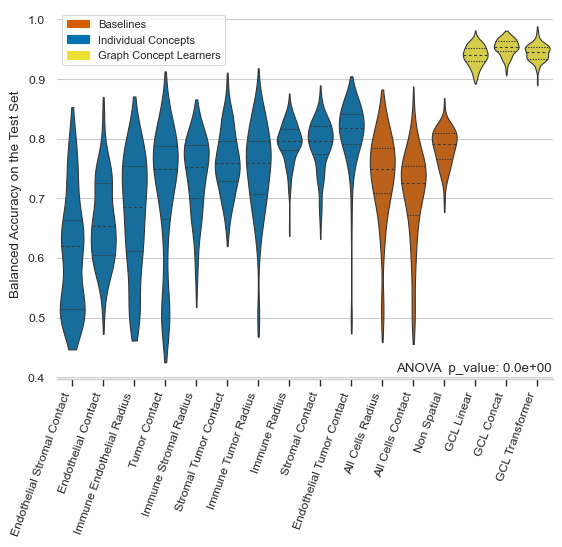

In [68]:
my_pal = {}
l = []
import matplotlib.patches as mpatches
for e_type in all_data_points["exp_name"].unique():
    if e_type in ["non_spatial", "all_cells_contact","all_cells_radius"]:
        my_pal[e_type] = "r"
    elif "gcl" in e_type:
        my_pal[e_type] = "y"
    else:
        my_pal[e_type] = "b"

    l.append(all_data_points.loc[(all_data_points["exp_type"]=="ER") & (all_data_points["exp_name"]==e_type), "test_balanced_accuracy"])
        
ax = sns.violinplot(linewidth = 0.8,
                    data=all_data_points.loc[all_data_points["exp_type"]=="ER"], 
                    x="exp_name", 
                    y="test_balanced_accuracy",
                    order=order,
                    cut=True,
                    scale="count",
                    palette=my_pal,
                    inner="quartile"
                   )
ax.set_xticklabels(better_labels, 
                   rotation=70,
                   horizontalalignment='right'
                  )
ax.set(xlabel ="", ylabel = "Balanced Accuracy on the Test Set", title ='')
ax.tick_params(axis='x', which='both', bottom=True)
legend_handles = [
    mpatches.Patch(color='r', label='Baselines'),
    mpatches.Patch(color='b', label='Individual Concepts'),
    mpatches.Patch(color='y', label='Graph Concept Learners')
]
plt.legend(handles=legend_handles, loc='upper left', fontsize='small')
sns.despine(left=True)
path_to_file = os.path.join(root_path_results, "violin_plots_ER.jpg")

f_score, p_value = f_oneway(*l)
plt.text(0.84, 0.03, f'ANOVA  p_value: {"{:.1e}".format(p_value)}', ha='center', va='center', transform=plt.gca().transAxes)
plt.savefig(path_to_file, bbox_inches='tight', dpi=300)

## Save things to file

### Long fomrat data for figure generation

In [356]:
path_to_file = os.path.join(root_path_results, "all_experiments_100_seeds_long_format.csv")
all_data_points.to_csv(path_to_file)

In [357]:
path_to_file = os.path.join(root_path_results, "all_random_experiments_100_seeds_long_format.csv")
sanity_check_all_data_points.to_csv(path_to_file)

### Formated data for tables in thesis report
#### All experiments

In [392]:
idx = pd.Index([
    ("ER", "mean"),("ER", "std"),("ER", "max"),("ER", "25%"),("ER", "50%"),("ER", "75%"),("ER", "min"),
    ("ERless", "mean"),("ERless", "std"),("ERless", "max"),("ERless", "25%"),("ERless", "50%"),("ERless", "75%"),("ERless", "min"),
])
all_data_points_formated = all_data_points.groupby(by=["exp_name","exp_type"]).describe().reset_index(col_level=1).droplevel(0, axis=1).pivot(index="exp_name", columns="exp_type").swaplevel(axis=1).reindex(columns=idx).astype(np.float64).sort_values(by=("ERless", "50%"), axis=0).round(3)

In [393]:
formated_names = all_data_points_formated.reset_index()["exp_name"].str.replace('_', ' ').str.title()
formated_names[len(formated_names)-1] = 'GCL Transfromer'
formated_names[len(formated_names)-2] = 'GCL Concat'
formated_names[len(formated_names)-3] = 'GCL Linear'
all_data_points_formated = all_data_points_formated.set_index(formated_names)

In [394]:
path_to_file = os.path.join(root_path_results, "all_experiments_100_seeds_formated.csv")
all_data_points_formated.to_csv(path_to_file)

#### Random experiments

In [403]:
sanity_check_formated = sanity_check_all_data_points.groupby(by=["exp_name"]).describe().reset_index(col_level=1).droplevel(0, axis=1).set_index("exp_name").sort_values(by=("50%"), axis=0).round(3)

In [406]:
formated_names = sanity_check_formated.reset_index()["exp_name"].str.replace('_', ' ').str.title()
formated_names[2] = 'GCL Transfromer'
formated_names[4] = 'GCL Concat'
formated_names[1] = 'GCL Linear'

In [411]:
sanity_check_formated = sanity_check_formated.set_index(formated_names).drop("count", axis=1)

,mean,std,min,25%,50%,75%,max
exp_name,,,,,,,
Immune Stromal Radius,0.495,0.038,0.391,0.474,0.497,0.517,0.579
GCL Linear,0.494,0.044,0.388,0.465,0.497,0.520,0.629
GCL Transfromer,0.497,0.031,0.438,0.476,0.498,0.510,0.580
Stromal Tumor Contact,0.500,0.053,0.362,0.465,0.498,0.540,0.614
GCL Concat,0.497,0.043,0.370,0.467,0.499,0.522,0.604
All Cells Contact,0.502,0.028,0.358,0.498,0.500,0.512,0.577
All Cells Radius,0.499,0.026,0.416,0.491,0.500,0.508,0.607
Endothelial Contact,0.497,0.044,0.310,0.481,0.500,0.518,0.611
Endothelial Stromal Contact,0.503,0.029,0.395,0.497,0.500,0.508,0.596


In [412]:
path_to_file = os.path.join(root_path_results, "all_random_experiments_100_seeds_formated.csv")
sanity_check_formated.to_csv(path_to_file)